In [30]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal
import pandas as pd

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

      solenoid_commanded  analog value (1-1024) (raw)  analog average
425                  0.0                        510.0          510.00
426                  0.0                        510.0          510.00
427                  0.0                        510.0          510.00
428                  0.0                        510.0          510.00
429                  0.0                        510.0          510.00
...                  ...                          ...             ...
5521               254.0                        579.0          579.17
5522               254.0                        579.0          579.19
5523               254.0                        579.0          579.21
5524               254.0                        579.0          579.23
5525               254.0                        579.0          579.24

[5101 rows x 3 columns]


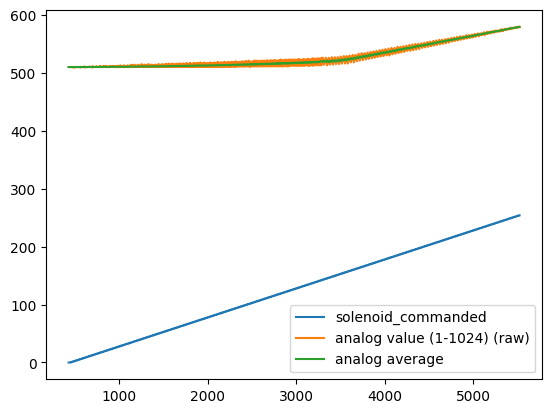

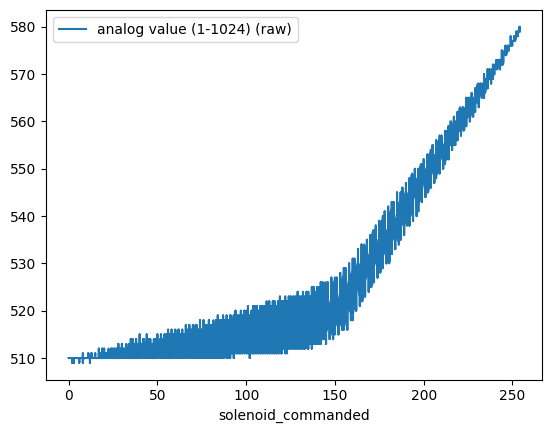

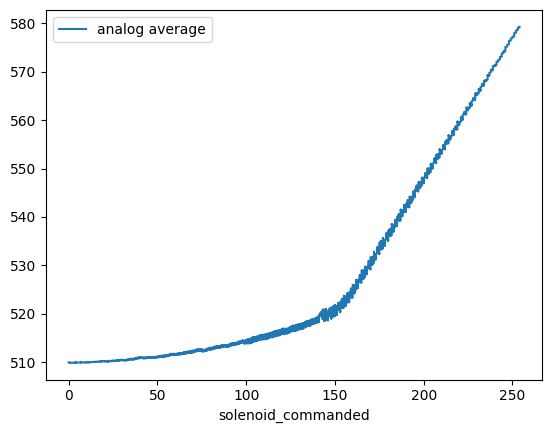

In [31]:
sensor_data = pd.read_csv("pin_5_6_solenoid_correction.csv")
sensor_data = sensor_data.truncate(before=400, after=5550)
sensor_data.drop(sensor_data.columns[3], axis=1, inplace=True)
sensor_data.drop(sensor_data.columns[0], axis=1, inplace=True)
# if interpolating
sensor_data = sensor_data.interpolate()

# if droppi"analog value (1-1024) (raw)"ng na values and collapsing
# sensor_data["analog value (1-1024) (raw)"] = sensor_data["analog value (1-1024) (raw)"][sensor_data["analog value (1-1024) (raw)"].notna()]
# sensor_data["solenoid_commanded"] = sensor_data["solenoid_commanded"][sensor_data["solenoid_commanded"].notna()]

mean_window = 50
sensor_data["analog average"] = sensor_data["analog value (1-1024) (raw)"].rolling(mean_window).mean().shift(-mean_window//2)
sensor_data.dropna(inplace = True)

sensor_data.plot()
sensor_data.plot(x="solenoid_commanded", y="analog value (1-1024) (raw)")
sensor_data.plot(x="solenoid_commanded", y="analog average")

print(sensor_data)

slope = 0.5806, intercept = 432


Text(0, 0.5, 'Hall effect sensor reading (0-1023)')

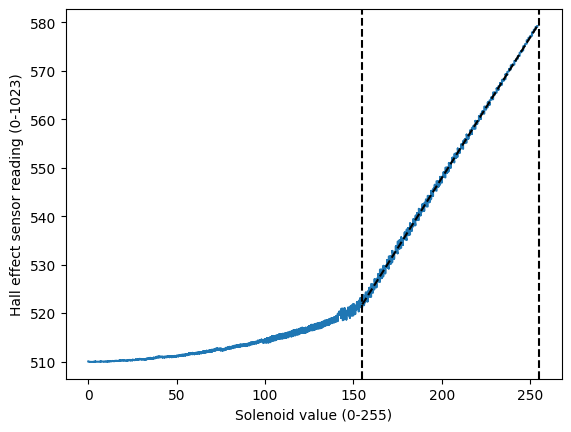

In [38]:
start_lin_reg = 155
end_lin_reg = 255
lin_reg_range = (start_lin_reg <= sensor_data["solenoid_commanded"]) & (sensor_data["solenoid_commanded"] <= end_lin_reg) & sensor_data["solenoid_commanded"].notnull()

# linear regression
A = np.vstack([sensor_data["solenoid_commanded"][lin_reg_range], np.ones(len(sensor_data["solenoid_commanded"][lin_reg_range]))]).T
slope, intercept = np.linalg.lstsq(A, sensor_data["analog average"][lin_reg_range], rcond=None)[0]
print(f"slope = {slope:.4f}, intercept = {intercept:.0f}")

plt.plot(sensor_data["solenoid_commanded"], sensor_data["analog average"])
plt.axvline(x = start_lin_reg, color = "black", linestyle = "dashed")
plt.axvline(x = end_lin_reg, color = "black", linestyle = "dashed")
plt.plot(sensor_data["solenoid_commanded"][lin_reg_range], sensor_data["solenoid_commanded"][lin_reg_range] * slope + intercept, color = "black", linestyle = "dashed")
plt.xlabel("Solenoid value (0-255)")
plt.ylabel("Hall effect sensor reading (0-1023)")